In [2]:
import Pkg; Pkg.add("DataFrames")
import Pkg; Pkg.add("CSV")
using Pkg; Pkg.activate()
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Revise")
import Pkg; Pkg.add("Convex")
import Pkg; Pkg.add("ECOS")
import Pkg; Pkg.add("LightGraphs")

using DataFrames, CSV
using Distributions, Random
using LinearAlgebra
using Convex, ECOS
using Plots
using LightGraphs
using SparseArrays

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

#1 (generic function with 1 method)

In [3]:
Random.seed!(2)
n = 50
l = 120
k = 4
beta = 0.2

# Make graph
G = watts_strogatz(n, k, beta)

# Convert to incidence matrix
# Matrix A represents a generator network
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate costs
fq = rand(Exponential(5), l) .+ 2
fl = rand(Exponential(5), l) .+ 2

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), l)
pmax = rand(Gamma(1.0, 1.0), m)


100-element Vector{Float64}:
 1.4875014712717034
 0.4786094723021005
 0.35476960122542667
 0.256304886039853
 0.3619932933520486
 0.15630110189370516
 0.21585738365007617
 2.3454321304166785
 0.5801480797111273
 0.07755191979920345
 0.9998061907304842
 2.60356192019468
 1.8362495711836055
 ⋮
 1.153397409707806
 1.7154934837355114
 0.41641098560804685
 0.46988660054394016
 1.1206039645774606
 0.022750476281067494
 0.6424551887855514
 2.302590502576441
 0.5787584286438936
 0.04072171886114353
 1.8049479523767582
 0.09511541092447875

In [42]:
# Matrix B maps the generators to the demand (n, l) (where does the electricity a generator generates goes to)
# Each colomn should have 1 entry that's one
B = zeros(n, l)
B[1:n, 1:n] = I(n)
for i in (n+1):l
    node = rand(1:n)
    B[node, i] = 1.0
end


In [43]:
Random.seed!(3)
M = rand(l, l)
num_cases = 500

cases = []
for _ in 1:num_cases
    d = rand(Uniform(0.0, 1.05), l) .* gmax
    
    opf = PowerManagementProblem(fq, fl, d, pmax, gmax, A, B)
    solve!(opf, ECOS_QUIET)
    
    if Int(opf.problem.status) == 2
        continue
    end
        
    push!(cases, (d=d, g=M*evaluate(opf.g)))
end

In [44]:
train_cases = cases[1:200]
test_cases = cases[201:end];

In [46]:

# Algorithm parameters
step_length = 10.0
max_iter = 100
batch_size = 1
test_batch_size = 4

4

In [47]:
Random.seed!(123)

# Initialize estimated costs
f̂q = rand(Exponential(5), l) .+ 2
f̂l = rand(Exponential(5), l) .+ 2


train_loss_hist = []
test_loss_hist = []
grad_hist = []
acc_hist = []

Any[]

In [48]:
Random.seed!(12345)

@time for iter in 1:max_iter
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(sample, train_cases, f̂q, f̂l, M, pmax, gmax, A, B)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    push!(acc_hist, abs(f̂q'fq) / (norm(f̂q) * norm(fq)) + abs(f̂l'fl) / (norm(f̂l) * norm(fl)))
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _, _ = stochastic_loss_and_grad(sample, test_cases, f̂q, f̂l, M, pmax, gmax, A, B)
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step - quadratic term
    η = (norm(dfq) > step_length) ? step_length : norm(dfq)
    f̂q = max.(f̂q - η*dfq/norm(dfq), 2)
    
    # Take projected gradient step - linear term
    η = (norm(dfl) > step_length) ? step_length : norm(dfl)
    f̂l = max.(f̂l - η*dfl/norm(dfl), 2)
end
println("Completed $(max_iter) iterations.")

  6.869061 seconds (6.41 M allocations: 1.843 GiB, 3.48% gc time)
Completed 100 iterations.


best_test_loss = 31.650770894082076
gen_size = 275983.1640642823
sqrt(best_test_loss / gen_size) = 0.010709047661537357


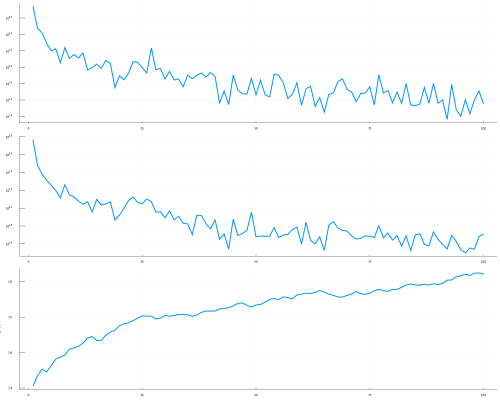

In [49]:
### best = x -> [minimum(x[1:k]) for k in 1:length(x)]

best_test_loss = minimum(test_loss_hist)
gen_size = mean([(1/2) * norm(case.g)^2 for case in test_cases]) / l

@show best_test_loss
@show gen_size
@show sqrt(best_test_loss / gen_size)


theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train loss", yscale=:log10),
    plot(test_loss_hist, ylabel="test loss", yscale=:log10),
    plot(acc_hist, ylabel="angle(f, f̂)"),
    layout=(3, 1),
    size = (2000,1600)
)

norm(example_case.g - M * ĝ) / norm(example_case.g) = 0.011044823198556979


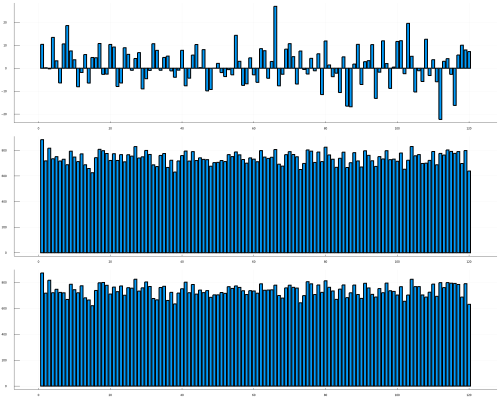

In [52]:
example_case = test_cases[6]

ĝ, opf, params = CarbonNetworks.solve_pmp(f̂q, fl, example_case.d, pmax, gmax, A, B)

@show norm(example_case.g - M*ĝ) / norm(example_case.g)

plot(
    bar(example_case.g - M*ĝ),
    bar(example_case.g),
    bar(M*ĝ),
    layout=(3, 1),
    size = (2000,1600)
)